<a href="https://colab.research.google.com/github/esoulard47/DataAnalyse_BankMarketing/blob/main/Gestion_de_fichiers_Big_Data_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gestion de fichiers Big Data  : création d'un modèle prédictif de survie lors du naufrage du Titanic

##Manipulation du fichier dans Spark

In [ ]:
from pyspark.sql import SparkSession

# Charger le fichier CSV avec l'option header
df = spark.read.csv('titanic_train.csv', header=True, inferSchema=True)

# Vérifier que c'est bien un DataFrame
print("Type de l'objet chargé :", type(df))
# c'est effectivement un dataframe

# Afficher les colonnes et leur type
print("Colonnes du DataFrame :", df.columns)
print("Types des colonnes :", df.dtypes)

# Afficher un échantillon des données
df.show(5)

# Compter le nombre de lignes dans le DataFrame
nombre_lignes = df.count()
print(f"Le DataFrame comporte {nombre_lignes} lignes.")

#réponse obtenue : le dataframe comporte 891 lignes

Type de l'objet chargé : <class 'pyspark.sql.dataframe.DataFrame'>
Colonnes du DataFrame : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Types des colonnes : [('PassengerId', 'int'), ('Survived', 'int'), ('Pclass', 'int'), ('Name', 'string'), ('Sex', 'string'), ('Age', 'double'), ('SibSp', 'int'), ('Parch', 'int'), ('Ticket', 'string'), ('Fare', 'double'), ('Cabin', 'string'), ('Embarked', 'string')]
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|   

Comparatif avec pandas

In [ ]:
# Convertir le DataFrame Spark en DataFrame Pandas
df_pandas = df.toPandas()

# Vérifier le type de l'objet converti
print("Type de l'objet converti :", type(df_pandas))

# Afficher un aperçu des données avec Pandas
print(df_pandas.head())

# Vérifier la taille en mémoire du DataFrame Pandas
print("Taille approximative en mémoire : {:.2f} MB".format(df_pandas.memory_usage(deep=True).sum() / (1024 * 1024)))
# Le fichier d'entrainement est effectivement petit, avec une taille en mémoire de 0,29 MB

# Pandas a des commandes très utiles n'existant pas en pySpark, comme head() ou describe()
# Mais Pandas n'est pas capable de traiter les grands jeux de données, pour lesquel Spark est conçu
# car Spark peut travailler en cluster, ce que Pandas ne peut pas faire

Type de l'objet converti : <class 'pandas.core.frame.DataFrame'>
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500  None        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250  None        S  
3      0            113803  53.1000  C123  

Conversion des colonnes qui devraient être en float

In [ ]:
# Rappel des Types des colonnes : [('PassengerId', 'int'), ('Survived', 'int'), ('Pclass', 'int'), ('Name', 'string'), ('Sex', 'string'), ('Age', 'double'), ('SibSp', 'int'), ('Parch', 'int'), ('Ticket', 'string'), ('Fare', 'double'), ('Cabin', 'string'), ('Embarked', 'string')]
# 'Age' et 'Fair' sont déjà en double (l'équivalent de float pour Spark), donc aucune nécessité de les changer
# 'name', 'sex', 'ticket', 'cabin', 'embarked' sont des string, aucun intérêt de les modifier non plus
# On peut éventuellement faire un one hot encoding pour analyse ultérieure, sous réserve que ce soit intéressant

# les colonnes que l'on peut changer en float sont 'passenger ID', 'Survived', 'PClass', 'Sibsp'et 'Parch'.
# Mais est-ce réellement pertinent ? Les ID pourraient être des string. il n'est pas pertinent d'en faire des nombres pour des calculs
# La survie et la classe des passagers sont des catégorisations. Elles ne sont pas non plus pertinentes pour des calculs
# Je choisi donc de tranformer uniquement les colonnes 'Sibsp' et 'Parch',
# parce que je ne peux pas déduire la nature de ces colonnes par leur entête

from pyspark.sql.functions import col

# Définir les colonnes à convertir
colonnes_a_convertir = ['SibSp', 'Parch']

# Appliquer la conversion pour chaque colonne
for colonne in colonnes_a_convertir:
    df = df.withColumn(colonne, col(colonne).cast('float'))

# Afficher les types des colonnes après conversion
print("Types des colonnes après conversion :", df.dtypes)

# Afficher les premières valeurs des colonnes converties pour vérification
df.select(*colonnes_a_convertir).show(5)

Types des colonnes après conversion : [('PassengerId', 'int'), ('Survived', 'int'), ('Pclass', 'int'), ('Name', 'string'), ('Sex', 'string'), ('Age', 'double'), ('SibSp', 'float'), ('Parch', 'float'), ('Ticket', 'string'), ('Fare', 'double'), ('Cabin', 'string'), ('Embarked', 'string')]
+-----+-----+
|SibSp|Parch|
+-----+-----+
|  1.0|  0.0|
|  1.0|  0.0|
|  0.0|  0.0|
|  1.0|  0.0|
|  0.0|  0.0|
+-----+-----+
only showing top 5 rows



Visualisation du jeu de données + analyse succinte

In [ ]:
# Appliquer la méthode describe() pour obtenir une vue d'ensemble
df.describe().show()

# Analyse : Je ne prend en compte que les colonnes pertinentes

# Passenger ID : 891 passagers, il semblerait qu'il n'y ai pas de ligne nulle. A confirmer

# Survived : 38 % de passagers survivants selon la moyenne si on suppose que 1 = survie. A confirmer

# Pclass : la majorité des passagers étaient en seconde et troisième, ce qui logique
# la première classe était réservée aux plus riches, fatalement minoritaires

# Age : Moyenne à presque 30 ans. Logique. On ne s'embarque par pour un nouveau continent lorsqu'on est vieux
# le plus âgé a quand même 80 ans, probablement un passager emmené par sa famille.
# la présence de passagers de moins d'un an confirme que des familles entières étaient sur le bateau

# Fare : Le prix moyen du billet était de 32 dollars (livres ? Les deux monnaies étaient acceptées)
# Il y a des passagers voyageant gratuitement. il est peut probable que ce soient des passagers conventionnels,
# peut-être des invités de la compagnie ou des chantiers navals à l'origine du bateau.
# On peut supposer qu'il s'agit des membres de l'équipage.
# Historiquement, le fondateur de la compagnie exploitant le bateau,
# la White Star, occupait l'une des suites. IL est peu probable qu'il ait acheté un billet
# Le prix le plus haut est de 512, peut-être des dollars. Le tarif le plus élevé était de 660 livres sterling de 1912
# le tarif a-t-il été converti en dollars actuels ?
# seulement 889 passagers ont été noté comme embarqués, mais le listing est de 891, ce qui fait 2 exceptions


+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

Gestion des valeurs nulles

In [ ]:
from pyspark.sql.functions import col, isnull, count

# Calculer le nombre de valeurs nulles pour chaque colonne
valeurs_nulles = [(c, df.filter(col(c).isNull()).count()) for c in df.columns]

# Afficher sous forme de tableau
for colonne, nombre_nulles in valeurs_nulles:
    print(f"Colonne: {colonne}, Valeurs nulles: {nombre_nulles}")

# NOTE : la commande count(isnull(col(c))) a renvoyé 100% de valeurs nulles dans toute les colonnes
# ce qui est un résultat faux
# j'ai donc opté pour un filtre.
# le premier code testé était :
#valeurs_nulles = df.select([
    #count(isnull(col(c))).alias(c) for c in df.columns
    #])


Colonne: PassengerId, Valeurs nulles: 0
Colonne: Survived, Valeurs nulles: 0
Colonne: Pclass, Valeurs nulles: 0
Colonne: Name, Valeurs nulles: 0
Colonne: Sex, Valeurs nulles: 0
Colonne: Age, Valeurs nulles: 177
Colonne: SibSp, Valeurs nulles: 0
Colonne: Parch, Valeurs nulles: 0
Colonne: Ticket, Valeurs nulles: 0
Colonne: Fare, Valeurs nulles: 0
Colonne: Cabin, Valeurs nulles: 687
Colonne: Embarked, Valeurs nulles: 2


In [ ]:
# la majorité des valeurs nulles est trouvé dans 'Age' et 'Cabin'
# Il n'est pas pertinent d'analyser 'cabin', car cette donnée a été visiblement mal remontée
# Excepté cette colonne, nous avons effectivement 2 passagers manquants à l'embarquement
# et 177 âges manquants

replacement des valeurs manquantes par None

In [ ]:
from pyspark.sql.functions import col

# Afficher les valeurs distinctes de la colonne 'Age'
print("Valeurs distinctes dans 'Age' :")
df.select("Age").distinct().show()

# le code précédent permet d'identifier que les valeurs manquantes dans la colonne 'age'
# sont répertoriées en tant que NULL
# Je compte donc le nombre d'occurence de NULL dans la colonne 'Age'

nombre_null_age = df.filter(col("Age").isNull()).count()
print(f"Nombre de valeurs NULL (manquantes) dans la colonne 'Age' : {nombre_null_age}")

# Le nombre obtenu est de 177, ce qui correspond au nombre de valeurs manquantes
# Toutes les valeurs manquantes de la colonne 'Age' sont donc NULL
# Il est ensuite facile de les remplacer


# Afficher les valeurs distinctes de la colonne 'Embarked'
print("Valeurs distinctes dans 'Embarked' :")
df.select("Embarked").distinct().show()
nombre_null_emb = df.filter(col("Embarked").isNull()).count()
print(f"Nombre de valeurs NULL (manquantes) dans la colonne 'Embarkedge' : {nombre_null_emb}")

# le code précédent permet d'identifier que les valeurs manquantes dans la colonne 'Embarked'
# sont répertoriées sous le terme NULL
# Je compte donc le nombre d'occurence de NULL dans la colonne 'Embarked' : 2 ce qui correspond au résultat précédent.

Valeurs distinctes dans 'Age' :
+----+
| Age|
+----+
| 8.0|
|70.0|
|0.92|
|0.42|
|0.67|
|0.83|
| 7.0|
|20.5|
|49.0|
|29.0|
|40.5|
|64.0|
|47.0|
|42.0|
|24.5|
|44.0|
|35.0|
|NULL|
|62.0|
|18.0|
+----+
only showing top 20 rows

Nombre de valeurs NULL (manquantes) dans la colonne 'Age' : 177
Valeurs distinctes dans 'Embarked' :
+--------+
|Embarked|
+--------+
|       Q|
|       C|
|       S|
|    NULL|
+--------+

Nombre de valeurs NULL (manquantes) dans la colonne 'Embarkedge' : 2


In [ ]:
from pyspark.sql.functions import when, col

# Remplacer les valeurs NULL par None dans toutes les colonnes
df = df.select(
    [when(col(c).isNull(), None).otherwise(col(c)).alias(c) for c in df.columns]
)

# Vérification
print("Vérification après transformation :")
df.show(10)
df.printSchema()

# Vérifier qu'il ne reste plus de valeurs NULL
for colonne in df.columns:
    null_count = df.filter(col(colonne).isNull()).count()
    print(f"Colonne '{colonne}': Nombre de valeurs NULL restantes : {null_count}")

# l'execution complète a prit 49 secondes.

Vérification après transformation :
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|  1.0|  0.0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|  1.0|  0.0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|  0.0|  0.0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|  1.0|  0.0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|  0.0|  0.0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. 

Suppression de toutes les valeurs nulle

In [ ]:
# Supprimer les lignes contenant au moins une valeur NULL
df_sans_null = df.dropna(how='any')

# Afficher les résultats
print("DataFrame après suppression des lignes contenant des valeurs NULL :")
df_sans_null.show()

# Afficher le nombre de lignes restantes
print(f"Nombre de lignes restantes : {df_sans_null.count()}")

# Il reste 183 lignes au final. Les 687 cabines vides ont supprimé la majeure partie du df.
# IL est pertinent de se poser la question d'exclure la colonne 'Cabin' avant cette étape
# pour conserver de la puissance statistique dans l'analyse et dans l'entrainement du modèle

# l'execution a prit 1 min 22 sec

DataFrame après suppression des lignes contenant des valeurs NULL :
+-----------+--------+------+--------------------+------+----+-----+-----+-----------+--------+-----------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|     Ticket|    Fare|      Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+-----------+--------+-----------+--------+
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|  1.0|  0.0|   PC 17599| 71.2833|        C85|       C|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|  1.0|  0.0|     113803|    53.1|       C123|       S|
|          7|       0|     1|McCarthy, Mr. Tim...|  male|54.0|  0.0|  0.0|      17463| 51.8625|        E46|       S|
|         11|       1|     3|Sandstrom, Miss. ...|female| 4.0|  1.0|  1.0|    PP 9549|    16.7|         G6|       S|
|         12|       1|     1|Bonnell, Miss. El...|female|58.0|  0.0|  0.0|     113783|   26.55|       C103|      

In [ ]:
# le df sera trop petit pour l'exploitation par Spark, je reviens en arrière
# objectif : ne supprimer les null que pour 'Age' et 'Embarked

# Supprimer les lignes où 'Age' ou 'Embarked' contient des NULL
df = df.dropna(subset=['Age', 'Embarked'])

# Vérifier le nombre de lignes restantes
print(f"Nombre de lignes restantes après suppression des NULL dans 'Age' et 'Embarked' : {df.count()}")

# Nombre de lignes restantes = 712


Nombre de lignes restantes après suppression des NULL dans 'Age' et 'Embarked' : 712


Vérification que nous ne travaillons qu'avec des données numériques

In [ ]:
from pyspark.ml.feature import StringIndexer

# Étape 1 : Identifier les colonnes catégoriques à convertir
colonnes_categoriques = ['Sex', 'Embarked']  # Liste des colonnes catégoriques à transformer

# Appliquer StringIndexer à chaque colonne catégorique
for colonne in colonnes_categoriques:
    indexer = StringIndexer(inputCol=colonne, outputCol=colonne + "_Index", handleInvalid='keep')
    df = indexer.fit(df).transform(df)

# Étape 2 : Afficher les colonnes après transformation
print("Colonnes après application de StringIndexer :")
df.show()

# Étape 3 : Identifier les colonnes non numériques
colonnes_non_numeriques = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked']

# Supprimer les colonnes non numériques
df = df.drop(*colonnes_non_numeriques)

# Étape 4 : Vérifier les colonnes restantes
print("Schéma du DataFrame après suppression des colonnes non numériques :")
df.printSchema()

# Afficher un échantillon des données
print("Échantillon des données finales :")
df.show(10)

# l'échantillon montre bien 100% de colonnes numériques

Colonnes après application de StringIndexer :
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+---------+--------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Sex_Index|Embarked_Index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+---------+--------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|  1.0|  0.0|       A/5 21171|   7.25| NULL|       S|      0.0|           0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|  1.0|  0.0|        PC 17599|71.2833|  C85|       C|      1.0|           1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|  0.0|  0.0|STON/O2. 3101282|  7.925| NULL|       S|      1.0|           0.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|  1.0|  0.0|          113803|   53.1| C123|       S|

Sélection des 5 colonnes utilisées pour le modèle

In [ ]:
# Le plus logique pour moi est de ne garder que les colonnes significatives
# Survived, Pclass, Age, Fare et Sex-Index.
# je ne sais pas à quoi correspondent les autres colonnes

# Liste des colonnes sélectionnées pour le modèle
colonnes_pour_modele = ['Survived', 'Pclass', 'Age', 'Fare', 'Sex_Index']

# Afficher la liste pour vérification
print("Colonnes sélectionnées pour le modèle :", colonnes_pour_modele)

# Créer un DataFrame avec uniquement les colonnes sélectionnées
df_modele = df.select(*colonnes_pour_modele)

# Afficher un échantillon du nouveau DataFrame
df_modele.show()


Colonnes sélectionnées pour le modèle : ['Survived', 'Pclass', 'Age', 'Fare', 'Sex_Index']
+--------+------+----+-------+---------+
|Survived|Pclass| Age|   Fare|Sex_Index|
+--------+------+----+-------+---------+
|       0|     3|22.0|   7.25|      0.0|
|       1|     1|38.0|71.2833|      1.0|
|       1|     3|26.0|  7.925|      1.0|
|       1|     1|35.0|   53.1|      1.0|
|       0|     3|35.0|   8.05|      0.0|
|       0|     1|54.0|51.8625|      0.0|
|       0|     3| 2.0| 21.075|      0.0|
|       1|     3|27.0|11.1333|      1.0|
|       1|     2|14.0|30.0708|      1.0|
|       1|     3| 4.0|   16.7|      1.0|
|       1|     1|58.0|  26.55|      1.0|
|       0|     3|20.0|   8.05|      0.0|
|       0|     3|39.0| 31.275|      0.0|
|       0|     3|14.0| 7.8542|      1.0|
|       1|     2|55.0|   16.0|      1.0|
|       0|     3| 2.0| 29.125|      0.0|
|       0|     3|31.0|   18.0|      1.0|
|       0|     2|35.0|   26.0|      0.0|
|       1|     2|34.0|   13.0|      0.0|
|      

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Colonnes à assembler pour former les features
colonnes_pour_assembler = ['Pclass', 'Age', 'Fare', 'Sex_Index']

# Initialisation du VectorAssembler
assembleur = VectorAssembler(inputCols=colonnes_pour_assembler, outputCol='features')

# Transformation du DataFrame pour ajouter la colonne 'features'
df_modele = assembleur.transform(df)

# Afficher les données transformées
df_modele.select('features', 'Survived').show(truncate=False)

# Nous avons un affichage de 'features', exemple : [3.0,22.0,7.25,0.0]
# La colonne "Survived" est correctement codée en 1 ou 0


+----------------------+--------+
|features              |Survived|
+----------------------+--------+
|[3.0,22.0,7.25,0.0]   |0       |
|[1.0,38.0,71.2833,1.0]|1       |
|[3.0,26.0,7.925,1.0]  |1       |
|[1.0,35.0,53.1,1.0]   |1       |
|[3.0,35.0,8.05,0.0]   |0       |
|[1.0,54.0,51.8625,0.0]|0       |
|[3.0,2.0,21.075,0.0]  |0       |
|[3.0,27.0,11.1333,1.0]|1       |
|[2.0,14.0,30.0708,1.0]|1       |
|[3.0,4.0,16.7,1.0]    |1       |
|[1.0,58.0,26.55,1.0]  |1       |
|[3.0,20.0,8.05,0.0]   |0       |
|[3.0,39.0,31.275,0.0] |0       |
|[3.0,14.0,7.8542,1.0] |0       |
|[2.0,55.0,16.0,1.0]   |1       |
|[3.0,2.0,29.125,0.0]  |0       |
|[3.0,31.0,18.0,1.0]   |0       |
|[2.0,35.0,26.0,0.0]   |0       |
|[2.0,34.0,13.0,0.0]   |1       |
|[3.0,15.0,8.0292,1.0] |1       |
+----------------------+--------+
only showing top 20 rows



Entraînement du modèle

In [ ]:
# Vérification du DataFrame transformé
transformed_data = assembleur.transform(df)
transformed_data.select("features", "Survived").show(5, truncate=False)

# le df est correctement affiché : exemple de features :[3.0,22.0,7.25,0.0]
# exemple de Survived : 0 ou 1


+----------------------+--------+
|features              |Survived|
+----------------------+--------+
|[3.0,22.0,7.25,0.0]   |0       |
|[1.0,38.0,71.2833,1.0]|1       |
|[3.0,26.0,7.925,1.0]  |1       |
|[1.0,35.0,53.1,1.0]   |1       |
|[3.0,35.0,8.05,0.0]   |0       |
+----------------------+--------+
only showing top 5 rows



Division du jeu de données

In [ ]:
# Diviser les données en training_data (70%) et test_data (30%)
training_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Afficher les tailles des ensembles
print(f"Nombre de lignes dans training_data : {training_data.count()}")
print(f"Nombre de lignes dans test_data : {test_data.count()}")

# Nombre de lignes dans training_data : 524
# Nombre de lignes dans test_data : 188


Nombre de lignes dans training_data : 524
Nombre de lignes dans test_data : 188


In [ ]:
from pyspark.ml.classification import RandomForestClassifier


In [ ]:
# Initialiser le RandomForestClassifier
random_forest = RandomForestClassifier(labelCol='Survived', featuresCol='features', maxDepth=5)

# Afficher les paramètres du modèle
print(random_forest.explainParams())

# 15 lignes affichées, avec des instructions au sujet des features du modèles.
# Je distingue des maximums, des minimums, des probabilités, des seuils
# C'est de toute évidence effectivement les paramètres d'un modèle


bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

Entraînement du modèle

In [ ]:
# Entraîner le modèle sur training_data
modele_rf = random_forest.fit(training_data)

# Afficher les informations du modèle
print("Modèle entraîné avec succès.")


Modèle entraîné avec succès.


In [ ]:
# Utiliser le modèle pour faire des prédictions sur test_data
predictions = modele_rf.transform(test_data)

# Afficher un aperçu des prédictions
predictions.select("features", "Survived", "prediction").show(10)

# Les prédictions sont correctement affichées.
# Elles sont visiblement une probabilité de survie comprise entre 0 et 1


+--------------------+--------+----------+
|            features|Survived|prediction|
+--------------------+--------+----------+
| [1.0,19.0,53.1,0.0]|       0|       0.0|
| [1.0,24.0,79.2,0.0]|       0|       0.0|
|[1.0,25.0,151.55,...|       0|       1.0|
|[1.0,27.0,211.5,0.0]|       0|       0.0|
| [1.0,29.0,66.6,0.0]|       0|       0.0|
|[1.0,30.0,27.75,0.0]|       0|       0.0|
|[1.0,31.0,50.4958...|       0|       0.0|
|[1.0,36.0,78.85,0.0]|       0|       0.0|
| [1.0,37.0,53.1,0.0]|       0|       0.0|
|[1.0,38.0,153.462...|       0|       1.0|
+--------------------+--------+----------+
only showing top 10 rows



Evaluation

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Initialiser l'évaluateur
evaluator = MulticlassClassificationEvaluator(
    labelCol='Survived',
    predictionCol='prediction',
    metricName='accuracy'
)

# Afficher les paramètres de l'évaluateur
print(evaluator.explainParams())

# les paramètres sont correctement affichés.
# Les colonnes prédiction, probabilité sont citées.


beta: The beta value used in weightedFMeasure|fMeasureByLabel. Must be > 0. The default value is 1. (default: 1.0)
eps: log-loss is undefined for p=0 or p=1, so probabilities are clipped to max(eps, min(1 - eps, p)). Must be in range (0, 0.5). The default value is 1e-15. (default: 1e-15)
labelCol: label column name. (default: label, current: Survived)
metricLabel: The class whose metric will be computed in truePositiveRateByLabel|falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel. Must be >= 0. The default value is 0. (default: 0.0)
metricName: metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss) (default: f1, current: accuracy)
predictionCol: prediction column name. (default: prediction, current: prediction)
probabilityCol: Column name for predicted class condi

In [ ]:
# Évaluer les prédictions
accuracy = evaluator.evaluate(predictions)

# Afficher le résultat
print(f"Précision du modèle : {accuracy:.2f}")

# Diviser avec une autre proportion
training_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=12)

# Valeur du modèle de prédiction : 0.78 pour une proportion de 80/20.
# Valeur du modèle : 0.78 pour une proportion de 90/10
# Valeur du modèle : 0.78 pour une proportion de 60/40.
# Seed 12 et proportion 80/20 :  0.78
# soit le jeu de données est très très grand, soit il est particulièrement petit
# ce qui explique pourquoi le modèle ne varie pas en fonction des proportions.



Précision du modèle : 0.78


##ANALYSE D'UNE BASE DE DONNEES SUR LE TITANIC
Création du modèle prédictif de survie en fonction des caractéristiques des passagers

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assemblage des colonnes numériques pour la corrélation
numeric_cols = ['Pclass', 'Age', 'Fare', 'Sex_Index']
assembler_corr = VectorAssembler(inputCols=numeric_cols, outputCol='numeric_features')
df_corr = assembler_corr.transform(df)

# Calcul de la matrice de corrélation
correlation_matrix = Correlation.corr(df_corr, 'numeric_features').head()[0]

# Afficher la matrice de corrélation
print("Matrice de corrélation :")
print(correlation_matrix.toArray())

# Voir analyse détaillée dans le cadre suivant :


Matrice de corrélation :
[[ 1.         -0.36590186 -0.55289322 -0.15082621]
 [-0.36590186  1.          0.09314252 -0.09903723]
 [-0.55289322  0.09314252  1.          0.18245683]
 [-0.15082621 -0.09903723  0.18245683  1.        ]]


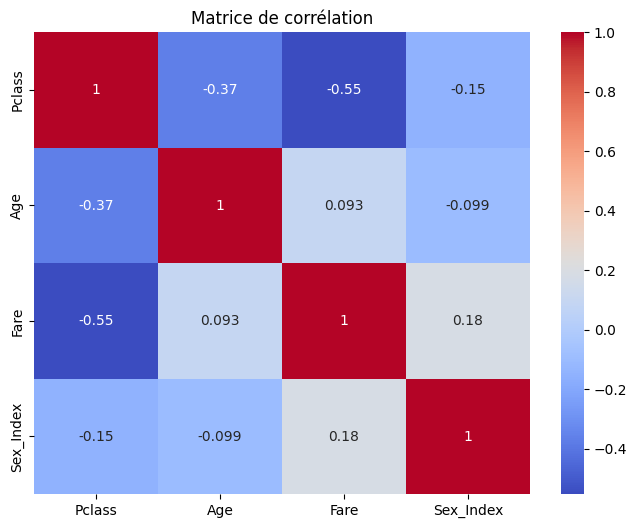

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matrice de corrélation
correlation_matrix = np.array([
    [1.0, -0.3659, -0.5529, -0.1508],
    [-0.3659, 1.0, 0.0931, -0.0990],
    [-0.5529, 0.0931, 1.0, 0.1824],
    [-0.1508, -0.0990, 0.1824, 1.0]
])

# Labels des variables
labels = ['Pclass', 'Age', 'Fare', 'Sex_Index']

# Création de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title("Matrice de corrélation")
plt.show()

# L'interprétation est plus facile avec une carte des températures :
# La corrélation la plus grande est entre la classe et le prix du billet. Elle est négative = -0.55
# Ce qui est assez logique : les passagers de première payent plus que ceux de 3ième classe
# Corrélation faible mais positive entre le prix et l'âge. On peut effectivement supposer
# que les passagers de première sont plus âgés que les jeunes qui voyagent à bas prix
# pour aller chercher une nouvelle vie sur le nouveau continent.
# Pas de réelle correlation entre l'âge et le sexe, autant d'hommes que de femme dans chaque classe d'âge
# de même que dans chaque classe de billet : pas de correltion avec le sexe